In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# !cp gdrive/My\ Drive/x96_s/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!ls -l

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 4714700
drwx------ 3 root root       4096 Apr  7 09:03 gdrive
-rw-r--r-- 1 root root       1066 Apr  7 09:08 history.csv
drwxr-xr-x 1 root root       4096 Apr  4 20:20 sample_data
drwx------ 3 root root       4096 Apr  7 09:04 tools
-rw------- 1 root root   21178039 Apr  7 09:05 weights
-rw------- 1 root root  801110144 Apr  7 09:03 X_test.npy
-rw------- 1 root root 2403311744 Apr  7 09:04 X_train.npy
-rw------- 1 root root  400555136 Apr  7 09:04 y_test.npy
-rw------- 1 root root 1201655936 Apr  7 09:04 y_train.npy


In [0]:
!cp gdrive/My\ Drive/12/weights29 weights

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
import tools._my_tools as mt
import tools._torch_tools as tt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
X_train, y_train, X_test, y_test = mt.loadData("",'float16',channels_last=False)

Device is cuda:0


In [0]:
import torchvision
VGG_FACTOR = 0.00001
class VggLoss(nn.Module):
    def __init__(self):
        super(VggLoss, self).__init__()

        model = torchvision.models.vgg19(pretrained=True).cuda()

        self.features = nn.Sequential(
#             nn.Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            # stop at relu4_4 (-10)
            *list(model.features.children())[:-10]
        )

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, output, target):
#         O = torch.cat((output,output,output),1)
#         T = torch.cat((target,target,target),1)
        outputFeatures = self.features(output)
        targetFeatures = self.features(target)

        loss = torch.norm(outputFeatures - targetFeatures, 2)

        return VGG_FACTOR * loss


class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.vgg = VggLoss()
        self.l1 = nn.L1Loss()

    def forward(self, output, target) -> torch.Tensor:
        return self.vgg(output, target) + self.l1(output, target)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
        
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

# model = Model().to(device)
# # model.to(device)
# if device == torch.device("cpu"):
#     print(summary(model, (2,96,96)))
# else:
#     print(summary(model.cuda(), (2,96,96)))

In [0]:
model = Model()
model.load_state_dict(torch.load("weights"))
loss = VggLoss()
training = Training2(model, device, X_train, y_train, X_test, y_test,loss_function=loss)

In [0]:
try:
    training.fit(32, 1, val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 32
epochs : 1
loss function : VggLoss(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 25

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[1](36/4074): Loss: 0.0066	ETA 0:54:34	Epoch Loss: 0.0065

In [0]:
!cp weights1 gdrive/My\ Drive/12/combined_loss/weights1
mt.toCSV("tmp.csv",training.history)
!cp tmp.csv gdrive/My\ Drive/12/combined_loss/.

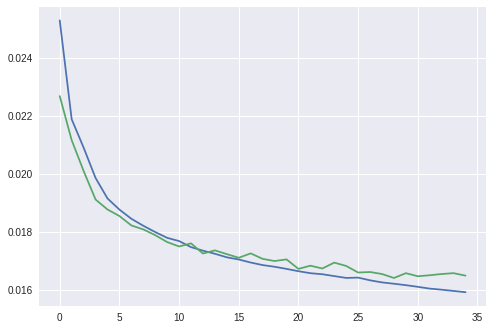

In [20]:
mt.plotHistory(training.history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


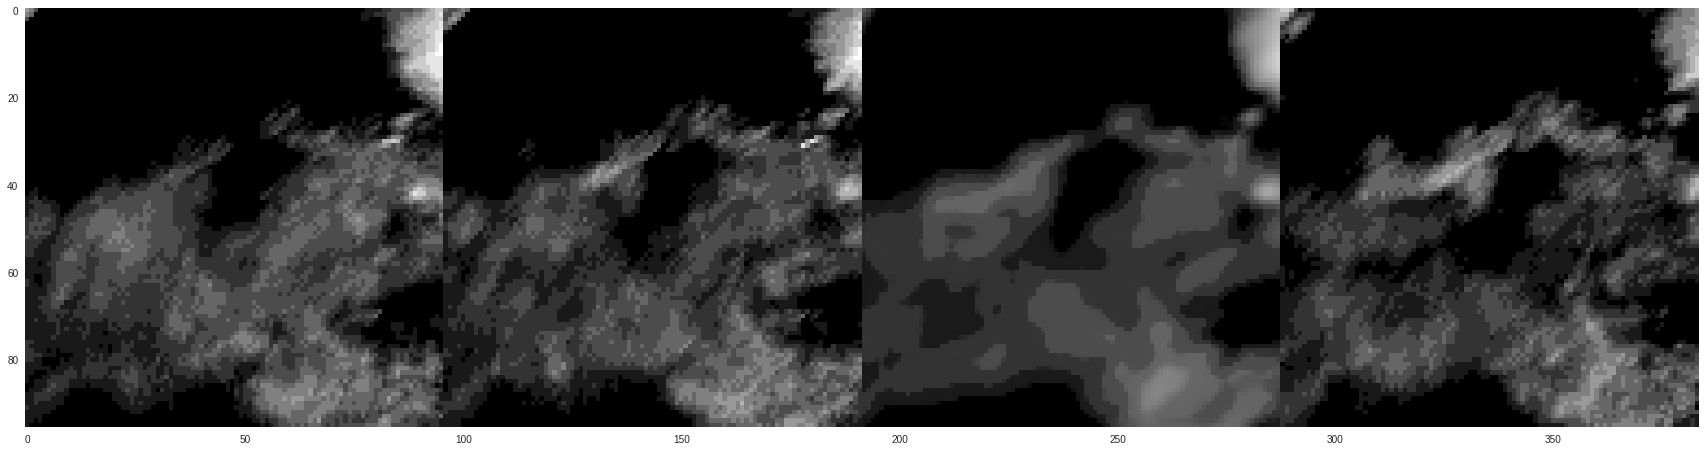

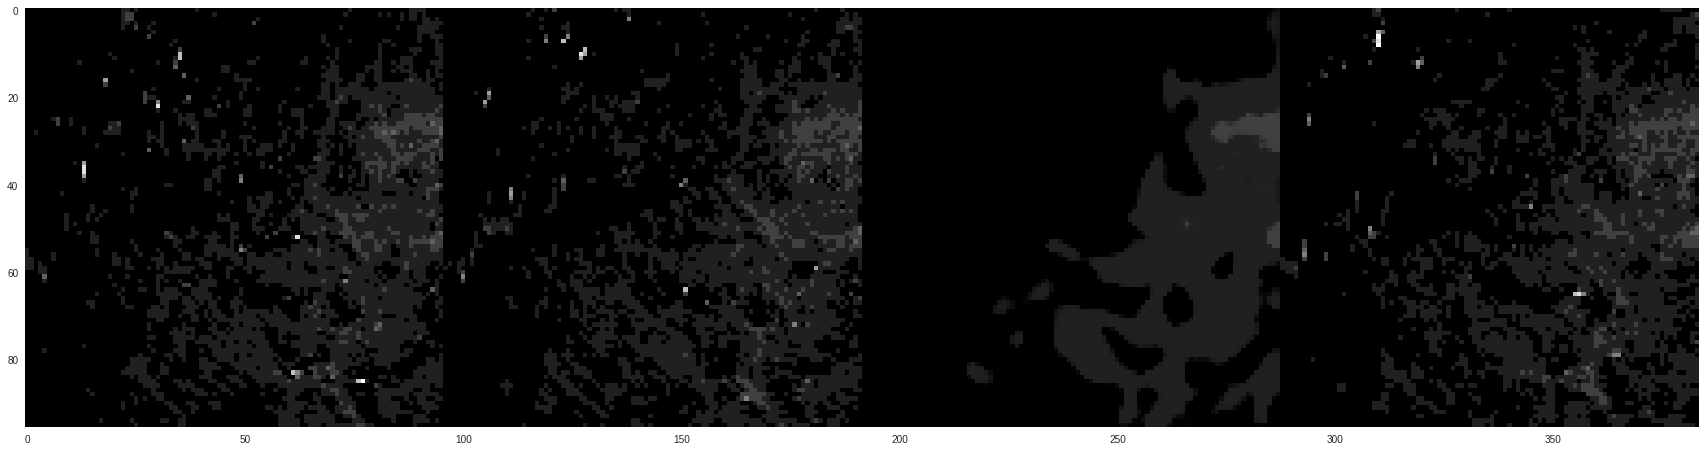

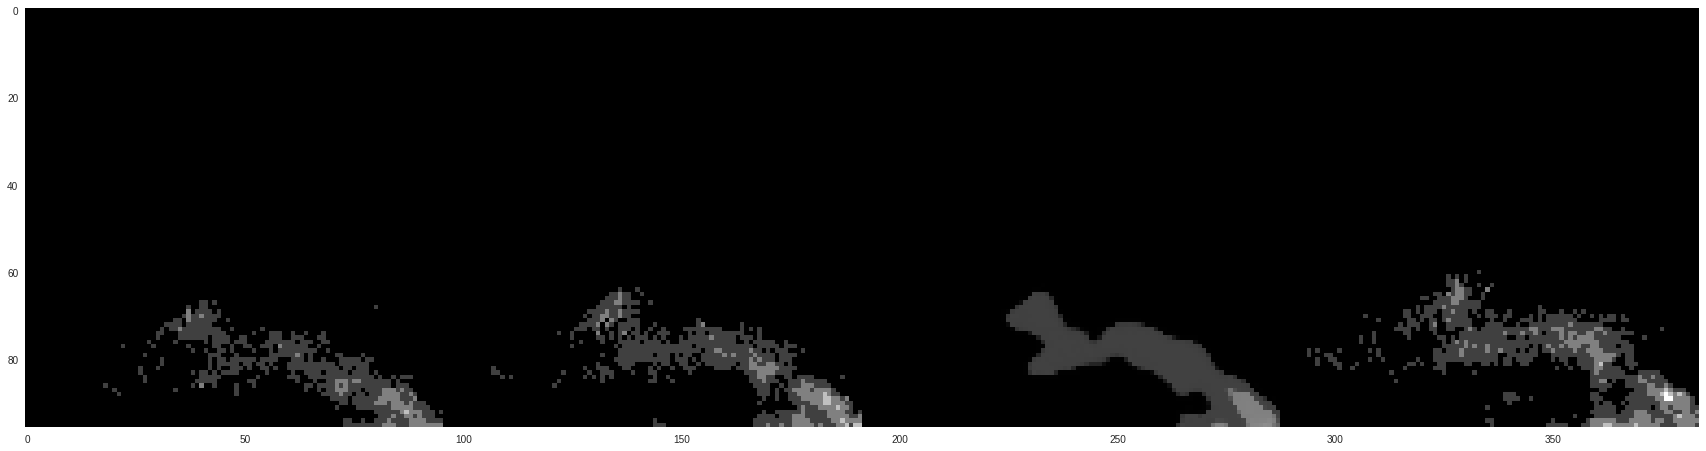

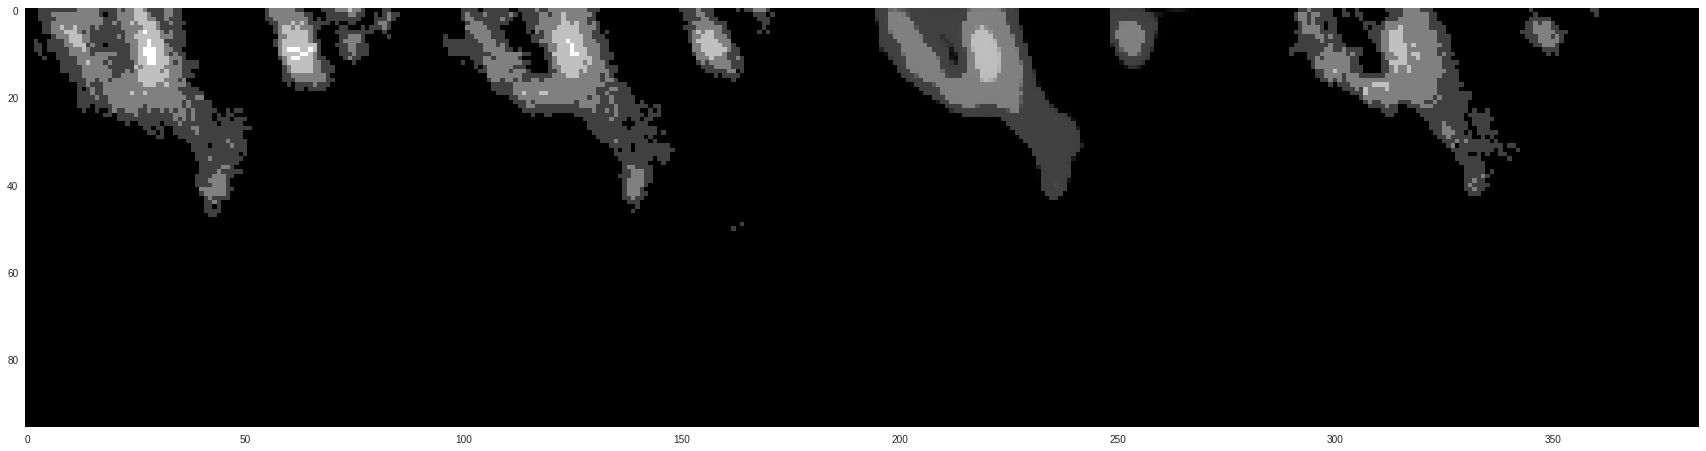

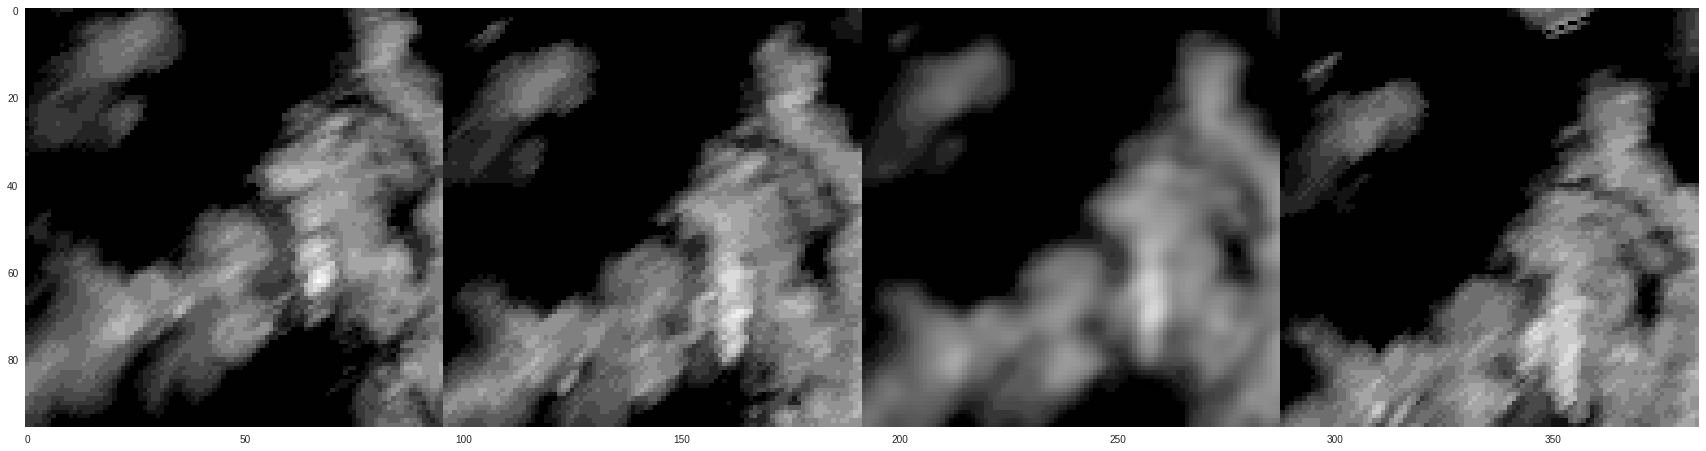

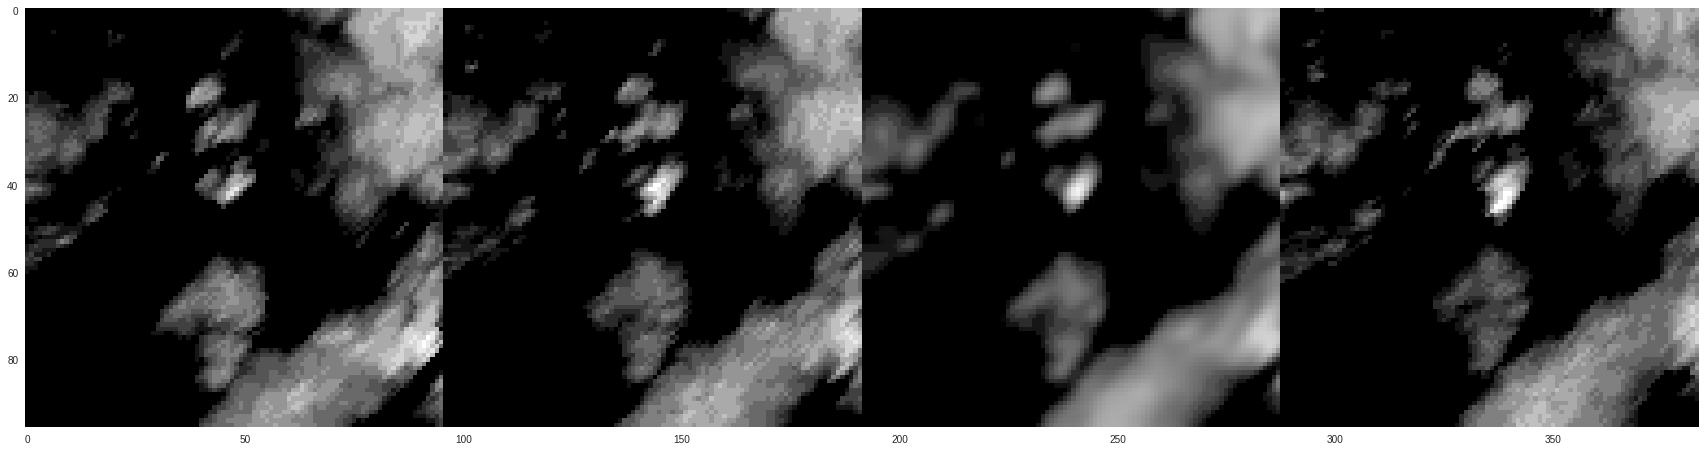

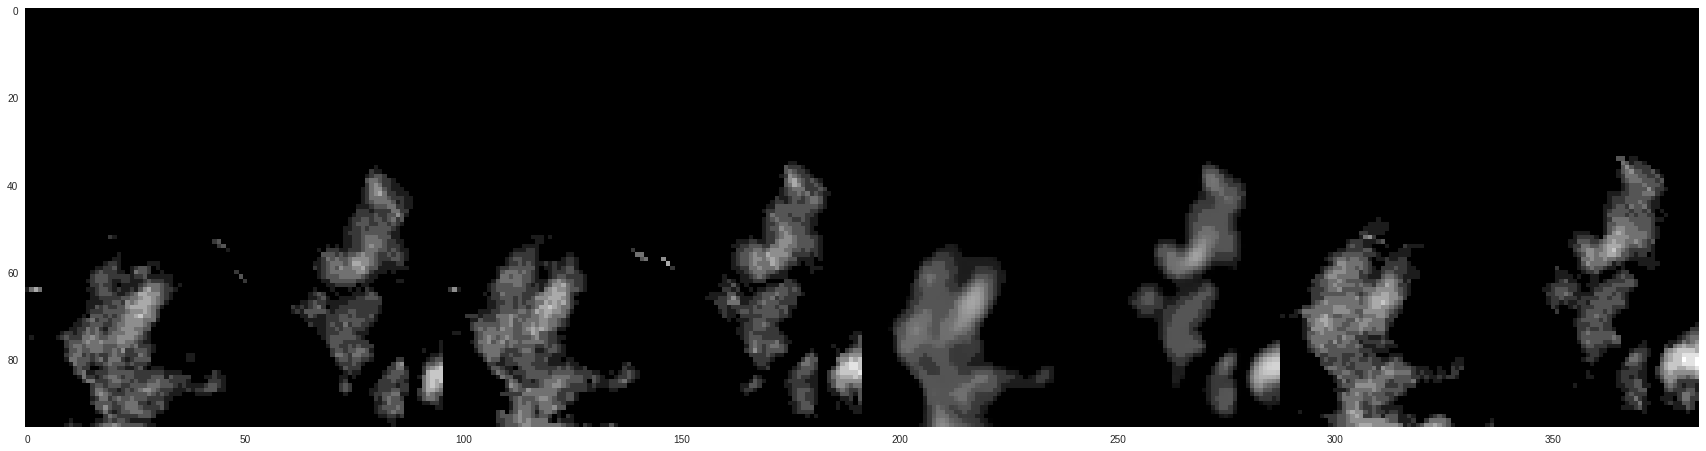

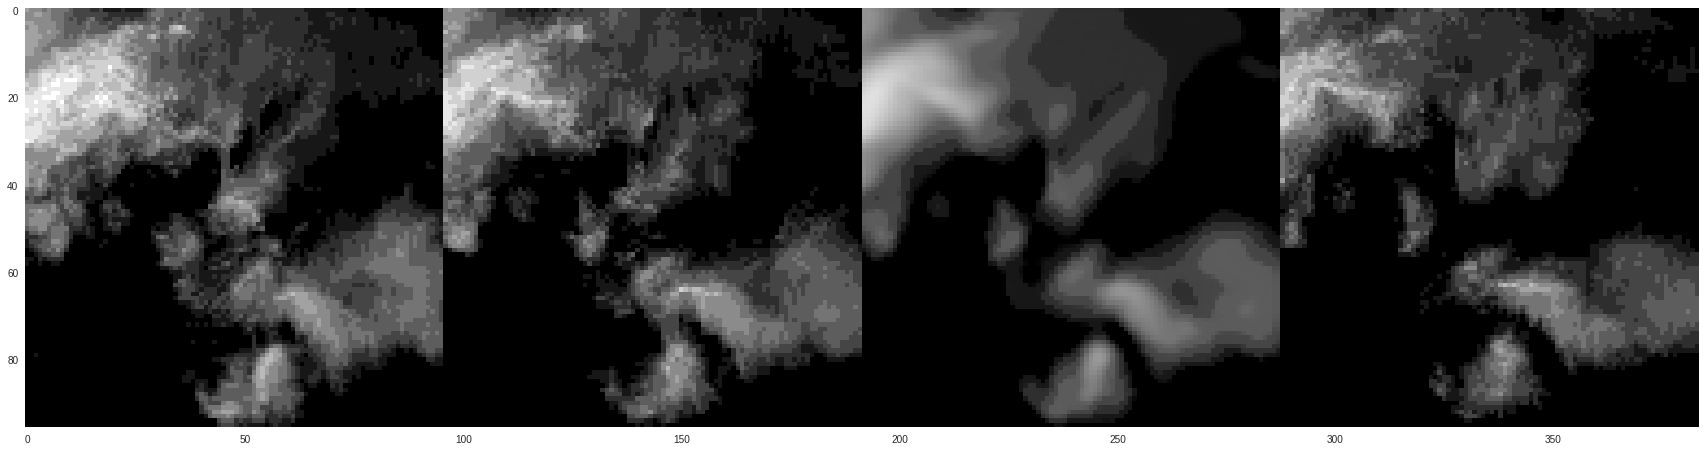

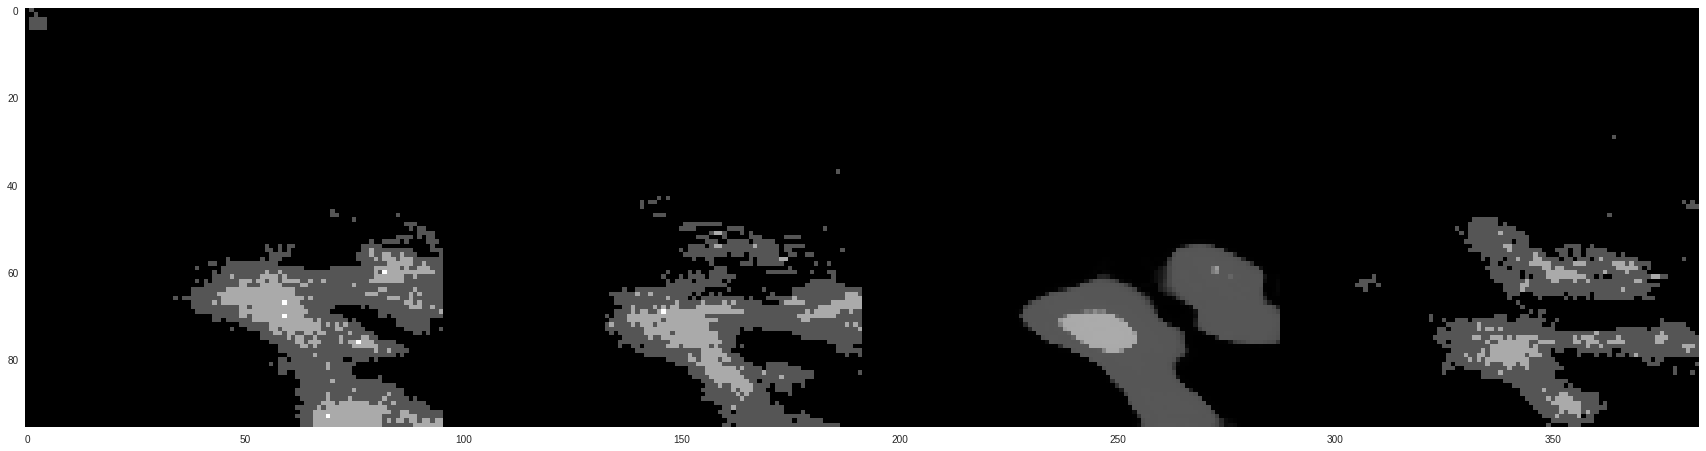

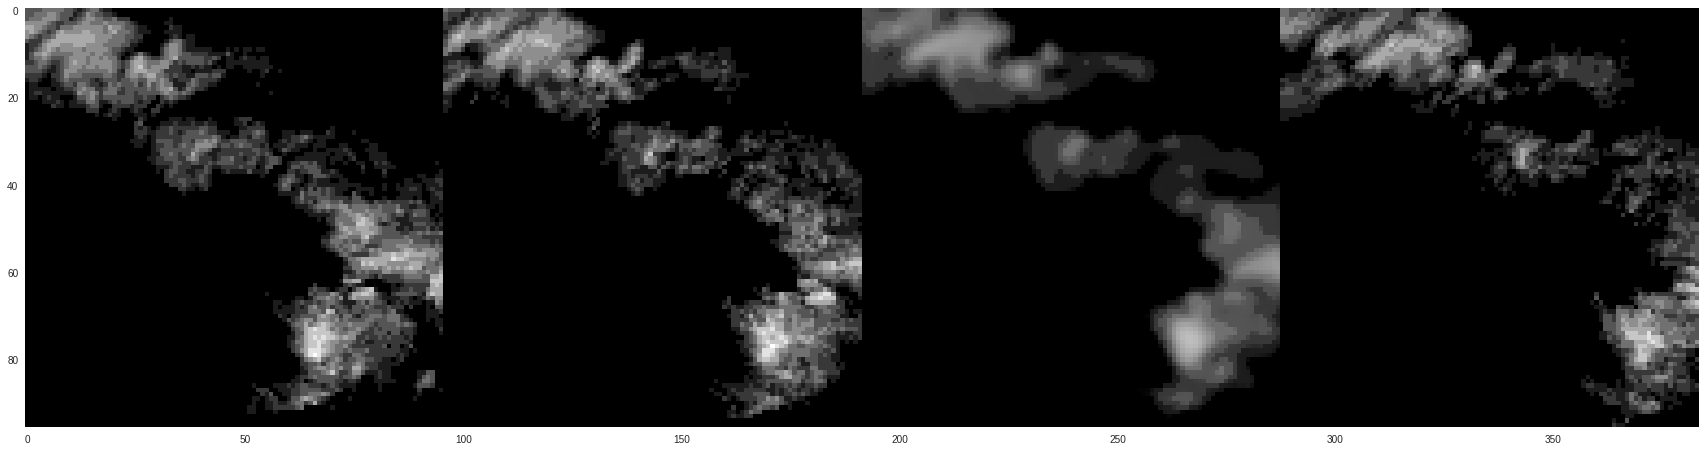

In [31]:
out = model( torch.tensor(X_test[0:10], dtype=torch.float).to(device) )
for i in range(10):
    mt.compare(i, X_test, y_test, out.cpu().detach().numpy(), folder="", channels_last=False)

In [0]:
torch.save(model.state_dict(), "weights")
# !cp weights gdrive/My\ Drive/weights3

In [0]:
model.load_state_dict(torch.load("weights5"))

In [22]:
!zip fig.zip *.png
# !zip weights.zip weights*

updating: 00.png (deflated 1%)
updating: 01.png (deflated 3%)
updating: 02.png (deflated 8%)
updating: 03.png (deflated 6%)
updating: 04.png (deflated 1%)
updating: 05.png (deflated 0%)
updating: 06.png (deflated 2%)
updating: 07.png (deflated 1%)
updating: 08.png (deflated 3%)
updating: 09.png (deflated 1%)


In [0]:
training.history = mt.fromCSV("history.csv")
training.history

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import time

class Training2():
	def __init__(self, model, device, X, y, X_val=None, y_val=None,
		loss_function=None, optimizer=None):

		# Dataset as numpy array
		self.setTrain(X,y)
		if X_val is not None:
			self.setVal(X_val, y_val)
		else:
			self.X_val = None
			self.y_val = None

		# Model stuff
		self.model = model
		self.device = device
		self.history = {
			'train' : [],
			'val' : []
		}

		self.loss_function = loss_function
		if self.loss_function is None:
			self.loss_function = nn.L1Loss()

		self.optimizer = optimizer 		# improve -> pass optim to class and initialize inside
		if self.optimizer is None:
			self.optimizer = optim.Adamax(model.parameters())

		# Load model on GPU
		self.model.to(self.device)

	# Returns batch as pytorch tensor on device.
	def getBatch(self, offset, batch_size, val=False):
		if val is True:
			X = self.X_val
			y = self.y_val
		else:
			X = self.X
			y = self.y

		input = torch.autograd.Variable(
			torch.tensor( X[ offset:offset + batch_size ], dtype=torch.float )
		)
		target = torch.autograd.Variable(
			torch.tensor( y[ offset:offset + batch_size ], dtype=torch.float )
		)
		return input.to(self.device), target.to(self.device)

	def fit(self, batch_size, n_epochs, val=False):
		
		#Print all of the hyperparameters of the training iteration:
		print("====== HYPERPARAMETERS ======")
		print("batch_size :", batch_size)
		print("epochs :", n_epochs)
		print("loss function :", self.loss_function)
		print("optimizer :", self.optimizer)
		print("device :",self.device)
		print("=" * 29)
		
		n_batch = self.X.shape[0] // batch_size
		
		start_T = int(time.time())
		
		for epoch in range(1,n_epochs+1):
			print("===> Epoch[{}]".format(epoch), end='', flush=True)
			epoch_T = time.time()
			epoch_loss = 0
			
			for it in range(n_batch):
				input, target = self.getBatch(it*batch_size, batch_size)
				self.optimizer.zero_grad()
				
				output = self.model(input)

				O = torch.cat((output,output,output),1).to(self.device)
				T = torch.cat((target,target,target),1).to(self.device)

				loss = self.loss_function(O, T)
				loss.backward()
				self.optimizer.step()
				
				loss_train = loss.item()
				epoch_loss += loss_train
				
				tick_T = time.time()
				print("\r", end='')
				print("===> Epoch[{}]({}/{}): Loss: {:.4f}\tETA {}\tEpoch Loss: {:.4f}"
					  .format(epoch, it + 1, n_batch, loss_train,
					  self.formatTime((tick_T - epoch_T) / (it + 1) * (n_batch - it + 1)),
					  epoch_loss / (it+1)), end='', flush=True)
				
			epoch_loss /= n_batch
			self.history['train'].append(epoch_loss)
			torch.save(self.model.state_dict(), "weights"+str(epoch))
			print("\nEpoch[{}] finished in {} with loss {}".format(epoch, self.formatTime(tick_T - epoch_T), epoch_loss))
			
			if val is True:
				self.validate(batch_size)
			
			print("\n----------------------------\n")
		print("Finished training of {} epochs in {}.".format(n_epochs, self.formatTime(int(time.time())-start_T)))
			
		return self.history

	def validate(self, batch_size):
		if self.X_val is None:
			print("Cannot validate, no validation dataset given.")
			return None

		loss_val = 0
		n_batch_val = self.X_val.shape[0] // batch_size

		print("Validating on {} samples.".format(n_batch_val * batch_size))

		start_T = int(time.time())
		for it in range(n_batch_val):
			input, target = self.getBatch(it*batch_size, batch_size, val=True)

			output = self.model(input)
			loss = self.loss_function(output, target)
			loss_val += loss.item()

			tick_T = time.time()
			print("\r", end='')
			print("===> Validating ({}/{}):\tETA {}\tValidation Loss: {:.4f}"
					  .format(it + 1, n_batch_val,
					  self.formatTime((tick_T - start_T) / (it + 1) * (n_batch_val - it + 1)),
					  loss_val / (it+1)), end='', flush=True)

		print("\nValidation loss = {:.4f}".format(loss_val / n_batch_val))
		self.history['val'].append( loss_val / n_batch_val )

		return loss_val / n_batch_val

	def setTrain(self, X, y):
		assert type(X) == type(y) == np.ndarray
		assert X.shape[0] == y.shape[0]
		assert X.shape[2:4] == y.shape[2:4]

		self.X = X
		self.y = y

	def setVal(self, X_val, y_val):
		assert type(X_val) == type(y_val) == np.ndarray
		assert X_val.shape[0] == y_val.shape[0]
		assert X_val.shape[2:4] == y_val.shape[2:4]

		self.X_val = X_val
		self.y_val = y_val

	# Takes t as number of seconds, returns formatted string as HH:MM:SS
	@staticmethod
	def formatTime(t):
		t = int(t)
		s = t % 60
		m = (t // 60) % 60
		h = t // 3600
		return str(h) + ":" + str(m).zfill(2) + ":" + str(s).zfill(2)